In [20]:
%pip install pytorch-lightning

Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
import torch.nn as nn
from torchvision import models
import pytorch_lightning as pl

NUM_CLASSES = 102  # same as before


class FlowersResNet(pl.LightningModule):
    def __init__(self, num_classes=NUM_CLASSES, lr=1e-4, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Backbone must match training definition
        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


# Load full Lightning checkpoint
ckpt_path = "Models/flowers_resnet18_pl.ckpt"
model = FlowersResNet.load_from_checkpoint(ckpt_path, map_location="cpu")
model.eval()

FlowersResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

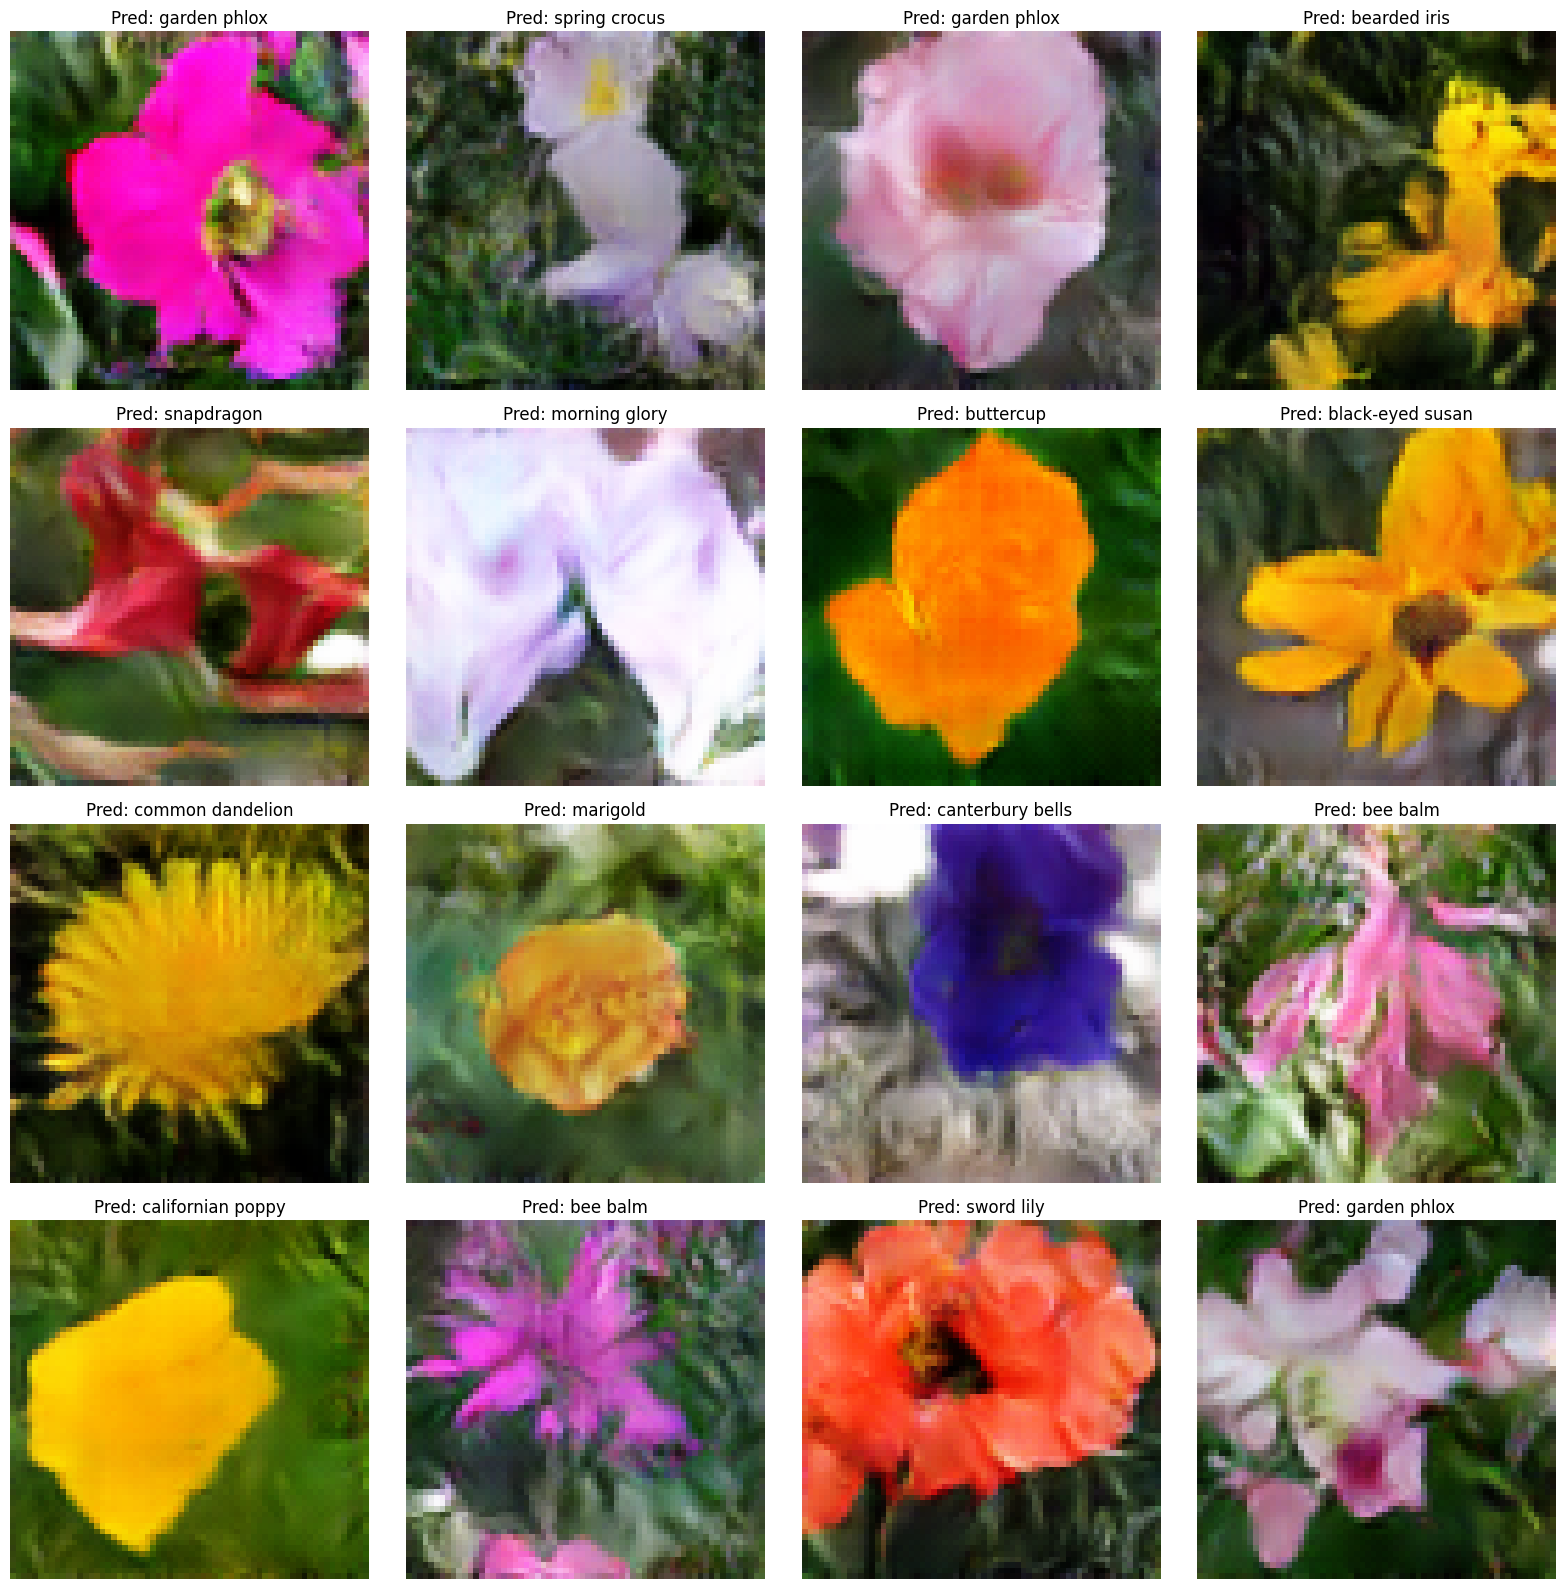

In [22]:
# Load GAN generator weights from Lightning .ckpt and classify generated samples
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn.functional as F

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Recreate Generator architecture (64x64 RGB) ---
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=3, image_size=64):
        super().__init__()
        self.image_size = image_size

        # For 64x64: start with 4x4, upsample to 8x8, 16x16, 32x32, 64x64
        self.lin1 = nn.Linear(latent_dim, 4 * 4 * 512)
        self.ct1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)  # 4->8
        self.bn1 = nn.BatchNorm2d(256)
        self.ct2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 8->16
        self.bn2 = nn.BatchNorm2d(128)
        self.ct3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # 16->32
        self.bn3 = nn.BatchNorm2d(64)
        self.ct4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)    # 32->64
        self.bn4 = nn.BatchNorm2d(32)
        self.conv = nn.Conv2d(32, channels, kernel_size=3, padding=1)    # 64->64

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 512, 4, 4)
        x = F.relu(self.bn1(self.ct1(x)))  # 8x8
        x = F.relu(self.bn2(self.ct2(x)))  # 16x16
        x = F.relu(self.bn3(self.ct3(x)))  # 32x32
        x = F.relu(self.bn4(self.ct4(x)))  # 64x64
        x = torch.tanh(self.conv(x))       # [-1, 1]
        return x


# --- Load generator weights from Lightning checkpoint ---
ckpt = torch.load("Models/gan_flowers_final.ckpt", map_location=device, weights_only=False)
state_dict = ckpt["state_dict"]

# Infer latent_dim from weight shape
latent_dim = state_dict["generator.lin1.weight"].shape[1]

gen = Generator(latent_dim=latent_dim, channels=3, image_size=64).to(device)

# Extract only generator.* weights and load into Generator
gen_state = {k.replace("generator.", ""): v for k, v in state_dict.items() if k.startswith("generator.")}
gen.load_state_dict(gen_state, strict=True)
gen.eval()


# --- Move classifier model to same device ---
model.to(device)
model.eval()

# Optional: class names from Flowers102
# Set download=True so this works even if Flowers102 is not already present locally
flowers_ds = datasets.Flowers102(root="./data", split="train", download=True, transform=transforms.ToTensor())
class_names = flowers_ds.classes

# Generate fake images
num_samples = 16
z = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    fake_imgs = gen(z)  # shape: (N, 3, 64, 64), range ~[-1, 1]

# Denormalize from [-1, 1] to [0, 1]
fake_imgs = (fake_imgs + 1) / 2.0
fake_imgs = fake_imgs.clamp(0, 1)

# Resize to 224x224 for the classifier
fake_for_cls = F.interpolate(fake_imgs, size=(224, 224), mode="bilinear", align_corners=False)

with torch.no_grad():
    logits = model(fake_for_cls)
    preds = logits.argmax(dim=1).cpu()

# Move images to CPU for plotting
fake_imgs_cpu = fake_imgs.cpu()

# Plot images with predicted labels
cols = 4
rows = (num_samples + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    img = fake_imgs_cpu[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    label_idx = preds[i].item()
    label_name = class_names[label_idx] if 0 <= label_idx < len(class_names) else str(label_idx)
    ax.set_title(f"Pred: {label_name}")
    ax.axis("off")

# Hide any unused subplots
for j in range(num_samples, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


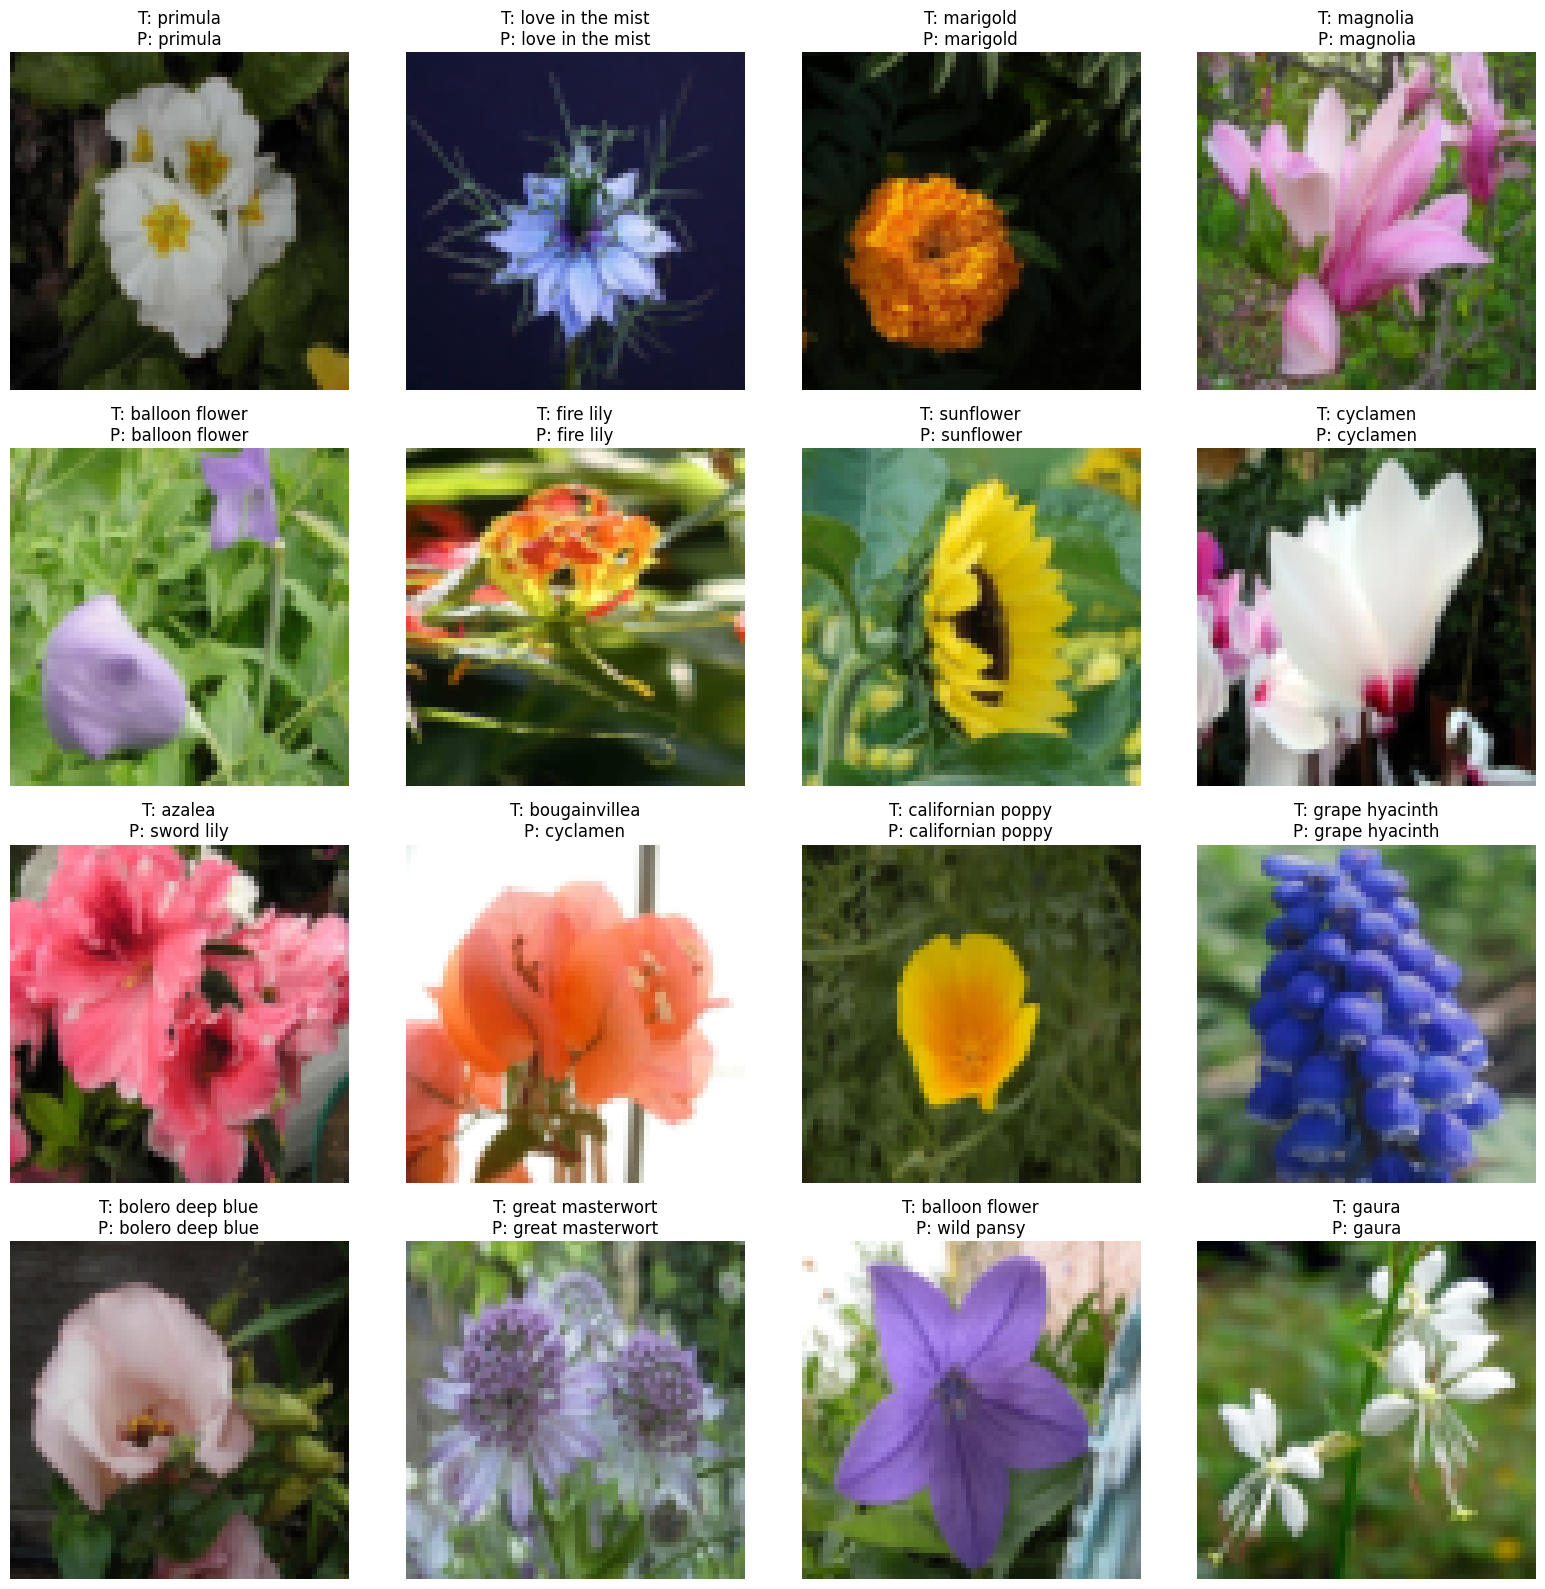

In [25]:
# Plot some real Flowers102 images scaled down to 64x64, with prediction + true label
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F

# Ensure dataset is available (uses same ./data root)
real_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

real_ds = datasets.Flowers102(
    root="./data",
    split="train",
    download=True,
    transform=real_transform,
)

# Class names (reuse same Flowers102 mapping as training)
class_names = real_ds.classes

num_real = 16
indices = torch.randperm(len(real_ds))[:num_real]

# Prepare batch for classifier: upsample to 224x224
imgs_batch = torch.stack([real_ds[i][0] for i in indices], dim=0)
labels_batch = torch.tensor([real_ds[i][1] for i in indices])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

imgs_for_cls = F.interpolate(imgs_batch.to(device), size=(224, 224), mode="bilinear", align_corners=False)

with torch.no_grad():
    logits = model(imgs_for_cls)
    preds = logits.argmax(dim=1).cpu()

cols = 4
rows = (num_real + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img = imgs_batch[i]
    true_label = labels_batch[i].item()
    pred_label = preds[i].item()

    ax = axes[i]
    ax.imshow(img.permute(1, 2, 0).numpy())
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]
    ax.set_title(f"T: {true_name}\nP: {pred_name}")
    ax.axis("off")

for j in range(num_real, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
